In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt #Open Korea Text
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

#먼저 데이터가 잘 읽어졌는지 확인한다.
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head() #데이터의 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
#stopword는 각 조사로, 의미를 가지지는 않으나 단어별로 구분하는 기준으로 적절하다

def load_data(train_data, test_data, num_words=10000):#load data - raw한 텍스트 파일을 처리할 수 있게 끔 정제
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 가지고 있는 단어나 stopword에 포함되어있지 않으면
                                                                    #제거해준다 !
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
nsmc = load_data(train_data, test_data)


In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [5]:
#print(get_encoded_sentence(X_train[0], index_to_word))
#print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

## 데이터셋 분포 확인  

이제 데이터셋의 문장의 길이를 pad_sequences를 통해 통일해 줘야한다.  
이 때 문장 최대 길이 maxlen의 값이 전체 모델 성능에 영향을 미치게 되는데, 이에 맞는 적절한 값을 찾기 위해서는  
전체 데이터셋의 분포를 확인하는 것이 도움이 된다.

In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969355837799927
문장길이 최대 :  116
문장길이 표준편차 :  12.843536204665021
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


##  pad_sequences  
분포를 확인했으니, 이제 PAD를 통해 문장 전체의 길이를 통일해 줘야한다.

In [7]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


In [8]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


## pre? &nbsp;  post?  
padding 방식은 pre와 post가 있다. 이는 PAD를 문장의 앞쪽과 뒤쪽 어느쪽에 할 것인지의 의미를 갖는데,  
RNN을 활용할 때에는 순차적으로 처리되는 입력데이터 때문에, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이  
미치게 된다. 따라서 영향을 가장 많이 미치는 마지막 입력이 의미를 가지고 있지 않은 PAD로 채워지는 것은 아주  
비효율적인 것이다.


# 모델 정의 및 학습 ! 

## validation set 분리

In [9]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


## RNN

In [10]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model_RNN = keras.Sequential()
model_RNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(keras.layers.LSTM(8))
model_RNN.add(keras.layers.Dense(8, activation='relu'))
model_RNN.add(keras.layers.Dense(1, activation='sigmoid')) 
model = model_RNN

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 2s 6ms/step - loss: 0.5180 - accuracy: 0.7287 - val_loss: 0.3703 - val_accuracy: 0.8404
Epoch 2/5
266/266 [==============================] - 1s 5ms/step - loss: 0.3418 - accuracy: 0.8558 - val_loss: 0.3473 - val_accuracy: 0.8478
Epoch 3/5
266/266 [==============================] - 1s 5ms/step - loss: 0.3183 - accuracy: 0.8656 - val_loss: 0.3412 - val_accuracy: 0.8508
Epoch 4/5
266/266 [==============================] - 1s 5ms/step - loss: 0.3055 - accuracy: 0.8702 - val_loss: 0.3429 - val_accuracy: 0.8471
Epoch 5/5
266/266 [==============================] - 1s 5ms/step - loss: 0.2931 - accuracy: 0.8750 - val_loss: 0.3530 - val_accuracy: 0.8484


In [12]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)


1537/1537 - 2s - loss: 0.3614 - accuracy: 0.8440
[0.3614051342010498, 0.8439693450927734]


In [13]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


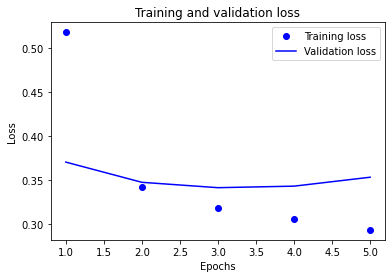

In [14]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

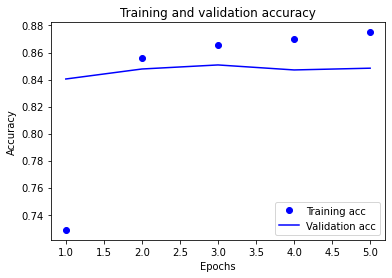

In [15]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 1-D Convolution Neural Network(1-D CNN)

In [16]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_CNN = keras.Sequential()
model_CNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_CNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(keras.layers.MaxPooling1D(5))
model_CNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(keras.layers.GlobalMaxPooling1D())
model_CNN.add(keras.layers.Dense(8, activation='relu'))
model_CNN.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model = model_CNN
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 9s 33ms/step - loss: 0.4790 - accuracy: 0.7682 - val_loss: 0.3508 - val_accuracy: 0.8450
Epoch 2/5
266/266 [==============================] - 1s 4ms/step - loss: 0.3312 - accuracy: 0.8593 - val_loss: 0.3359 - val_accuracy: 0.8554
Epoch 3/5
266/266 [==============================] - 1s 4ms/step - loss: 0.3022 - accuracy: 0.8740 - val_loss: 0.3368 - val_accuracy: 0.8522
Epoch 4/5
266/266 [==============================] - 1s 4ms/step - loss: 0.2805 - accuracy: 0.8851 - val_loss: 0.3385 - val_accuracy: 0.8533
Epoch 5/5
266/266 [==============================] - 1s 4ms/step - loss: 0.2578 - accuracy: 0.8980 - val_loss: 0.3472 - val_accuracy: 0.8504


In [18]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3565 - accuracy: 0.8494
[0.35650917887687683, 0.8494415879249573]


In [19]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


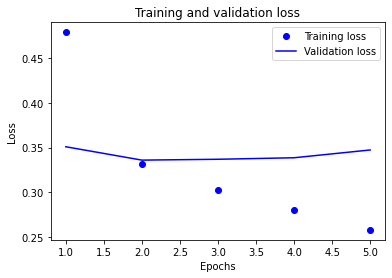

In [20]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

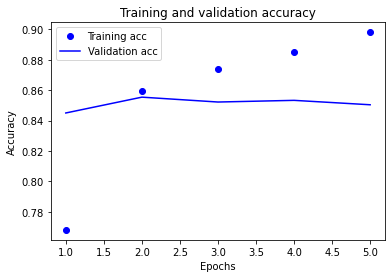

In [21]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Global Max Pooling 1D

In [22]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_GMP = keras.Sequential()
model_GMP.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_GMP.add(keras.layers.GlobalMaxPooling1D())
model_GMP.add(keras.layers.Dense(8, activation='relu'))
model_GMP.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model = model_GMP
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 1s 3ms/step - loss: 0.5635 - accuracy: 0.7452 - val_loss: 0.4095 - val_accuracy: 0.8228
Epoch 2/5
266/266 [==============================] - 1s 3ms/step - loss: 0.3681 - accuracy: 0.8416 - val_loss: 0.3534 - val_accuracy: 0.8447
Epoch 3/5
266/266 [==============================] - 1s 3ms/step - loss: 0.3214 - accuracy: 0.8637 - val_loss: 0.3456 - val_accuracy: 0.8492
Epoch 4/5
266/266 [==============================] - 1s 3ms/step - loss: 0.2956 - accuracy: 0.8767 - val_loss: 0.3477 - val_accuracy: 0.8498
Epoch 5/5
266/266 [==============================] - 1s 3ms/step - loss: 0.2766 - accuracy: 0.8861 - val_loss: 0.3536 - val_accuracy: 0.8481


In [24]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 1s - loss: 0.3625 - accuracy: 0.8436
[0.36251509189605713, 0.843643844127655]


In [25]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


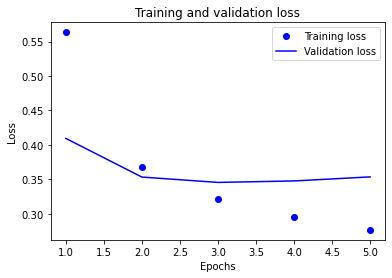

In [26]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

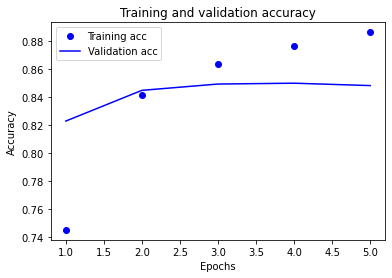

In [27]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Word2Vec &nbsp;..? &nbsp; Word Embedding ! 
자연어는 무수히 많은 자음, 모음, 음절, 어절 등으로 구성되어있다. 그에 따라서 라벨링 비용이 많이 들게 되어있는데,  
이를 위해 단어의 특성을 저차원의 벡터값으로 표현할 수 있는 word embedding 기법을 사용해준다면 좋을 것이다.  
사실 이곳에서도 이미 embedding 기법은 사용되었는데, 각 모델별로 첫번째로 구성되어있던 <strong>embedding 레이어</strong>가 바로  
그것이다.  

### Embedding Layer
이 레이어는 <strong>우리가 가진 사전의 단어 개수 x 워드 벡터 사이즈</strong> 만큼의 크기를 가진 학습 파라미터이다  
  
일단은.. embedding layer를 사용하기전에, 워드벡터를 다루는데 유용한 gensim을 사용해야한다.

In [28]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [29]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w',encoding='utf-8')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
 #단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [30]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-0.12915455, -0.12267687, -0.08928754,  0.21137407, -0.11446782,
       -0.13238001, -0.09650459, -0.11751273, -0.11225845, -0.09796387,
       -0.10649113, -0.05105629, -0.12609039, -0.1528805 , -0.10851205,
       -0.1239063 ], dtype=float32)

In [31]:
word_vectors.similar_by_word("영화")

[('다', 0.9810593128204346),
 ('고', 0.9686173796653748),
 ('더', 0.9615063667297363),
 ('어', 0.9612940549850464),
 ('.', 0.9601684808731079),
 ('보다', 0.9593440294265747),
 ('한참', 0.9581114053726196),
 ('야', 0.9517711400985718),
 (',', 0.9387186169624329),
 ('스럽', 0.9280079007148743)]

In [33]:
from gensim.models import KeyedVectors
import gensim
#word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
#word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
#vector = word2vec['영화']
#vector     # 무려 300dim의 워드 벡터입니다.

ko_model = gensim.models.Word2Vec.load('./ko/ko.bin')
word_vectors.similar_by_word("영화")

UnpicklingError: invalid load key, '9'.

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

In [ ]:
word_vectors.similar_by_word("영화")